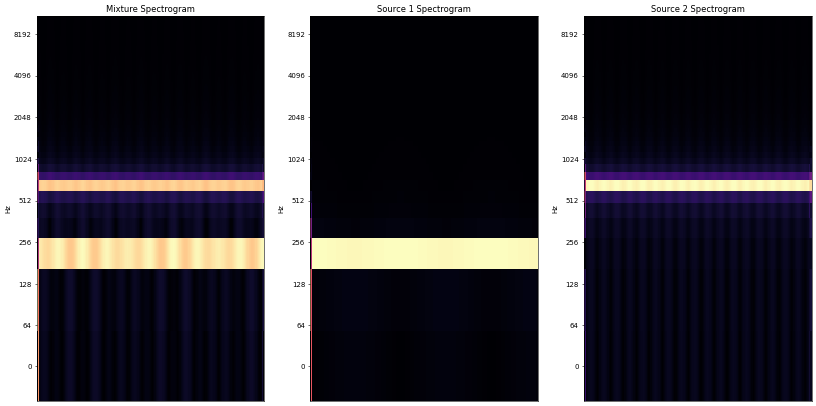

In [5]:
import IPython.display as ipd
import librosa.display as lrd
import matplotlib.pyplot as plt
import numpy as np
import speechbrain
import speechbrain as sb
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from IPython.display import Audio
from speechbrain.dataio.dataio import read_audio
from torch.utils.data import DataLoader, Dataset

N = 100
f_th = 200
fs = 8000

T = 10000
t = torch.arange(0, T).unsqueeze(0)
f1 = torch.randint(5, f_th, (N, 1))
f2 = torch.randint(f_th, 400, (N, 1))
batch_size = 10

source1 = torch.sin(2 * np.pi * (f1 / fs) * t)
source2 = torch.sin(2 * np.pi * (f2 / fs) * t)
mixture = source1 + source2
N_train = 90
train_dataset = data_utils.TensorDataset(source1[:N_train], source2[:N_train], mixture[:N_train])
test_dataset = data_utils.TensorDataset(source1[N_train:], source2[N_train:], mixture[N_train:])

train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size)
test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size)

# now let's visualize the frequency spectra for the dataset
fft_size = 200

plt.figure(figsize=[20, 10], dpi=50)

plt.subplot(131)
mix_gt = mixture[N_train]
mix_spec = torch.sqrt((torch.view_as_real(torch.stft(mix_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(mix_spec.numpy(), y_axis='log')
plt.title('Mixture Spectrogram')

plt.subplot(132)
source1_gt = source1[N_train]
source1_spec = torch.sqrt((torch.view_as_real(torch.stft(source1_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source1_spec.numpy(), y_axis='log')
plt.title('Source 1 Spectrogram')

plt.subplot(133)
source2_gt = source2[N_train]
source2_spec = torch.sqrt((torch.view_as_real(torch.stft(source2_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source2_spec.numpy(), y_axis='log')
plt.title('Source 2 Spectrogram')

plt.show()

In [6]:
%%capture
!pip install speechbrain

In [8]:
# define the model


class simpleseparator(nn.Module):
    def __init__(self, fft_size, hidden_size, num_sources=2):
        super(simpleseparator, self).__init__()
        self.masking = nn.LSTM(input_size=fft_size // 2 + 1, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output_layer = nn.Linear(in_features=hidden_size * 2, out_features=num_sources * (fft_size // 2 + 1))
        self.fft_size = fft_size
        self.num_sources = num_sources

    def forward(self, inp):
        # batch x freq x time x realim
        y = torch.view_as_real(torch.stft(inp, n_fft=self.fft_size, return_complex=True))

        # batch X freq x time
        mag = torch.sqrt((y ** 2).sum(-1))
        phase = torch.atan2(y[:, :, :, 1], y[:, :, :, 0])

        # batch x time x freq
        mag = mag.permute(0, 2, 1)

        # batch x time x feature
        rnn_out = self.masking(mag)[0]

        # batch x time x (nfft*num_sources)
        lin_out = self.output_layer(rnn_out)

        # batch x time x nfft x num_sources
        lin_out = nn.functional.relu(lin_out.reshape(lin_out.size(0), lin_out.size(1), -1, self.num_sources))

        # reconstruct in time domain
        sources = []
        all_masks = []
        for n in range(self.num_sources):
            sourcehat_mask = (lin_out[:, :, :, n])
            all_masks.append(sourcehat_mask)

            # multiply with mask and magnitude
            sourcehat_dft = (sourcehat_mask * mag).permute(0, 2, 1) * torch.exp(1j * phase)

            # reconstruct in time domain with istft
            sourcehat = torch.istft(sourcehat_dft, n_fft=self.fft_size)
            sources.append(sourcehat)
        return sources, all_masks, mag


# test_forwardpass
model = simpleseparator(fft_size=fft_size, hidden_size=300)
est_sources, _, _ = model.forward(mixture[:5])

In [9]:
class SeparationBrain(sb.Brain):
    def __init__(self, train_loss, modules, opt_class):
        super(SeparationBrain, self).__init__(modules=modules, opt_class=opt_class)
        self.train_loss = train_loss

    def compute_forward(self, mix):
        """Forward computations from the mixture to the separated signals."""

        # Get the estimates for the sources
        est_sources, _, _ = self.modules.mdl(mix)

        est_sources = torch.stack(est_sources, dim=-1)

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_sources.size(1)
        if T_origin > T_est:
            est_sources = nn.functional.pad(est_sources, (0, 0, 0, T_origin - T_est))
        else:
            est_sources = est_sources[:, :T_origin, :]

        return est_sources

    def compute_objectives(self, targets, est_sources):
        """Computes the loss functions between estimated and ground truth sources"""
        if self.train_loss == 'l1':
            return (est_sources - targets).abs().mean()
        elif self.train_loss == 'si-snr':
            return sb.nnet.losses.get_si_snr_with_pitwrapper(targets, est_sources).mean()

    def fit_batch(self, batch):
        """Trains one batch"""
        # Unpacking batch list
        source1, source2, mix = batch
        targets = torch.stack([source1, source2], dim=-1)

        est_sources = self.compute_forward(mix)
        loss = self.compute_objectives(targets, est_sources)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for test batches"""

        source1, source2, mix = batch
        targets = torch.stack([source1, source2], dim=-1)

        est_sources = self.compute_forward(mix)

        si_snr = sb.nnet.losses.get_si_snr_with_pitwrapper(targets, est_sources)
        si_snr_mean = si_snr.mean().item()
        print('VALID SI-SNR = {}'.format(-si_snr_mean))
        return si_snr.mean().detach()


def optimizer(x):
    return torch.optim.Adam(x, lr=0.0001)


N_epochs = 10
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
    train_loss='l1',
    modules={'mdl': model},
    opt_class=optimizer

)


separator.fit(
    epoch_counter,
    train_loader,
    test_loader)

100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


VALID SI-SNR = 4.921563625335693


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


VALID SI-SNR = 8.948319435119629


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


VALID SI-SNR = 11.226025581359863


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


VALID SI-SNR = 13.427938461303711


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


VALID SI-SNR = 15.083406448364258


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


VALID SI-SNR = 16.36334991455078


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


VALID SI-SNR = 18.633670806884766


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


VALID SI-SNR = 19.71079444885254


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


VALID SI-SNR = 20.951885223388672


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

VALID SI-SNR = 21.37876319885254


In [10]:
%%capture
!pip install librosa


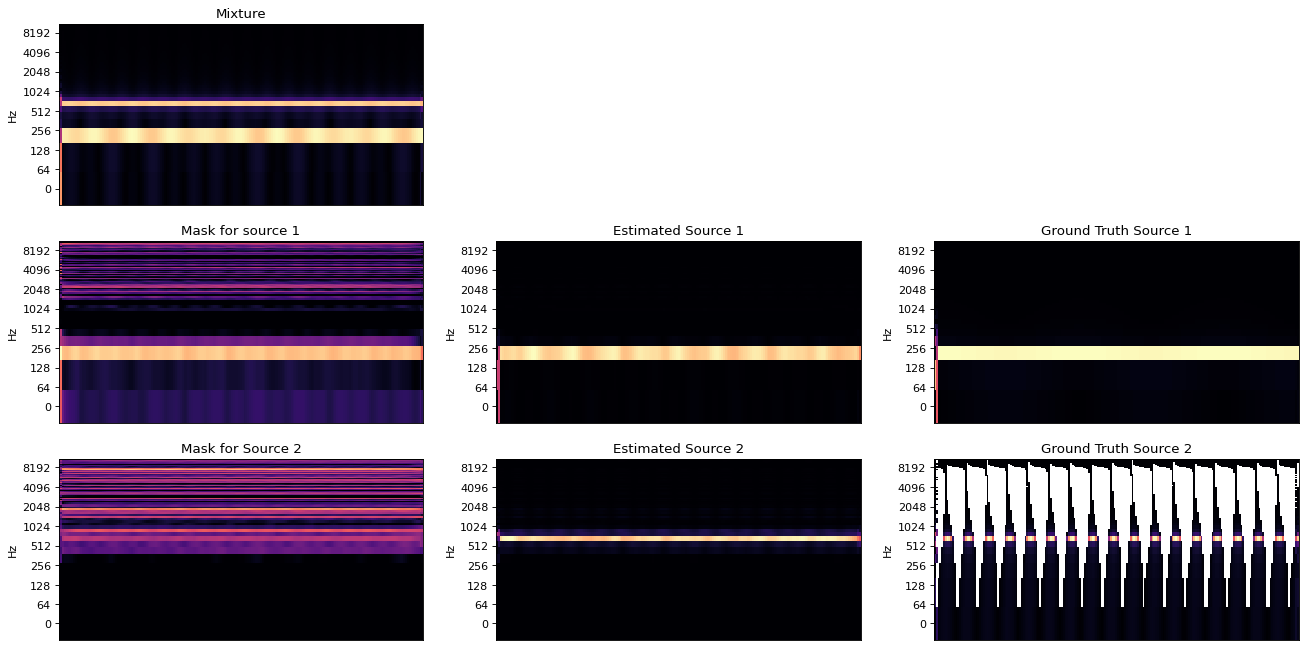

In [11]:
estimated_sources, all_masks, mag = separator.modules.mdl.forward(mixture[N_train:])


plt.figure(figsize=[20, 10], dpi=80)

plt.subplot(331)
mag = mag[0].t().numpy()
lrd.specshow(mag, y_axis='log')
plt.title('Mixture')

plt.subplot(334)
mask1 = all_masks[0][0].detach().t().numpy()
lrd.specshow(mask1, y_axis='log')
plt.title('Mask for source 1')

plt.subplot(335)
masked1 = mask1 * mag
lrd.specshow(masked1, y_axis='log')
plt.title('Estimated Source 1')

plt.subplot(336)
source1_gt = source1[N_train]
source1_spec = torch.sqrt((torch.view_as_real(torch.stft(source1_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source1_spec.numpy(), y_axis='log')
plt.title('Ground Truth Source 1')

plt.subplot(337)
mask2 = all_masks[1][0].detach().t().numpy()
lrd.specshow(mask2, y_axis='log')
plt.title('Mask for Source 2')

plt.subplot(338)
masked2 = mask2 * mag
lrd.specshow(masked2, y_axis='log')
plt.title('Estimated Source 2')

plt.subplot(339)
source2_gt = source2[N_train]
source2_spec = torch.sqrt((torch.view_as_real(torch.stft(source2_gt, n_fft=fft_size, return_complex=True)**2)).sum(-1))
lrd.specshow(source2_spec.numpy(), y_axis='log')
plt.title('Ground Truth Source 2')

plt.show()

In [12]:
%%capture
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AADx5I8oV0IdekCf80MSkxMia/mixture_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAAZI7ZezKyHFGPdus6hn2v_a/mixture_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACh4Yy4H-Ii2I0mr_b1lQdXa/mixture_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAAenTlEsoj1-AGbCxeJfMHoa/mixture_3.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC-awQo-9NFVVULuVwaHKKWa/source1_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AABVKWtdVhXZE6Voq1I_c6g5a/source1_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC9EfjTTwL0dscH16waP9s-a/source1_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC5Ozb4rS9qby268JSIy5Uwa/source1_3.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AABlonG910Ms2l-rTN5ct3Oka/source2_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACDOqEgyXIeA2r1Rkf7VgQTa/source2_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACTYGAG0LOh6HvxpVYoqO_Da/source2_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACPmq-ZJNzfh4bnO34_8mfAa/source2_3.wav

In [13]:
mixture_0 = read_audio('mixture_0.wav').squeeze()
source1_0 = read_audio('source1_0.wav').squeeze()
source2_0 = read_audio('source2_0.wav').squeeze()

mixture_1 = read_audio('mixture_1.wav').squeeze()
source1_1 = read_audio('source1_1.wav').squeeze()
source2_1 = read_audio('source2_1.wav').squeeze()

mixture_2 = read_audio('mixture_2.wav').squeeze()
source1_2 = read_audio('source1_2.wav').squeeze()
source2_2 = read_audio('source2_2.wav').squeeze()

mixture_3 = read_audio('mixture_3.wav').squeeze()
source1_3 = read_audio('source1_3.wav').squeeze()
source2_3 = read_audio('source2_3.wav').squeeze()

train_mixs = [mixture_0, mixture_1, mixture_2]
train_source1s = [source1_0, source1_1, source1_2]
train_source2s = [source2_0, source2_1, source2_2]

Audio(mixture_0, rate=16000)

In [14]:
class source_separation_dataset(Dataset):
    def __init__(self, train_mixs, train_source1s, train_source2s):
        self.mixs = train_mixs
        self.train_source1s = train_source1s
        self.train_source2s = train_source2s

    def __len__(self):
        return len(self.mixs)

    def __getitem__(self, idx):
        mix = self.mixs[idx]
        source1 = self.train_source1s[idx]
        source2 = self.train_source2s[idx]
        return mix, source1, source2


train_dataset_audio = source_separation_dataset(train_mixs, train_source1s, train_source2s)
valid_dataset_audio = source_separation_dataset([mixture_2], [source1_2], [source2_2])

train_loader_audio = DataLoader(train_dataset_audio, batch_size=1)
valid_loader_audio = DataLoader(valid_dataset_audio, batch_size=1)

In [15]:
fft_size = 1024
model_audio = simpleseparator(fft_size=fft_size, hidden_size=300)


def optimizer(x):
    return torch.optim.Adam(x, lr=0.0005)


N_epochs = 100
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
    train_loss='si-snr',
    modules={'mdl': model_audio},
    opt_class=optimizer

)


separator.fit(
    epoch_counter,
    train_loader_audio,
    valid_loader_audio)

100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


VALID SI-SNR = -21.010391235351562


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


VALID SI-SNR = -18.96896743774414


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


VALID SI-SNR = -18.401803970336914


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


VALID SI-SNR = -17.09296226501465


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


VALID SI-SNR = -16.374797821044922


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


VALID SI-SNR = -15.670256614685059


100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


VALID SI-SNR = -15.018585205078125


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


VALID SI-SNR = -14.395303726196289


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


VALID SI-SNR = -13.657071113586426


100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


VALID SI-SNR = -12.640039443969727


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


VALID SI-SNR = -11.815685272216797


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


VALID SI-SNR = -11.254788398742676


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


VALID SI-SNR = -10.882073402404785


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


VALID SI-SNR = -10.522068977355957


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


VALID SI-SNR = -10.096724510192871


100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


VALID SI-SNR = -9.7462739944458


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


VALID SI-SNR = -9.511689186096191


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


VALID SI-SNR = -9.371975898742676


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


VALID SI-SNR = -9.141982078552246


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


VALID SI-SNR = -8.889920234680176


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


VALID SI-SNR = -8.70762825012207


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


VALID SI-SNR = -8.47357177734375


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


VALID SI-SNR = -8.233232498168945


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


VALID SI-SNR = -7.987979888916016


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


VALID SI-SNR = -7.776778221130371


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


VALID SI-SNR = -7.590007305145264


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


VALID SI-SNR = -7.461136341094971


100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


VALID SI-SNR = -7.306606769561768


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


VALID SI-SNR = -7.133813381195068


100%|██████████| 1/1 [00:00<00:00,  7.44it/s]


VALID SI-SNR = -7.047067642211914


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


VALID SI-SNR = -7.005374908447266


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


VALID SI-SNR = -6.853711128234863


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


VALID SI-SNR = -6.755715847015381


100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


VALID SI-SNR = -6.591826915740967


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


VALID SI-SNR = -6.440517425537109


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


VALID SI-SNR = -6.298949241638184


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


VALID SI-SNR = -6.136325836181641


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


VALID SI-SNR = -5.985972881317139


100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


VALID SI-SNR = -5.902712821960449


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


VALID SI-SNR = -5.969325065612793


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


VALID SI-SNR = -5.826808452606201


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


VALID SI-SNR = -5.552072525024414


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


VALID SI-SNR = -5.572102069854736


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


VALID SI-SNR = -5.293192386627197


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


VALID SI-SNR = -5.529018878936768


100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


VALID SI-SNR = -5.433617115020752


100%|██████████| 1/1 [00:00<00:00,  7.23it/s]


VALID SI-SNR = -5.796940803527832


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


VALID SI-SNR = -5.366736888885498


100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


VALID SI-SNR = -5.157202243804932


100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


VALID SI-SNR = -5.462534427642822


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


VALID SI-SNR = -5.306131839752197


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


VALID SI-SNR = -5.151639461517334


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


VALID SI-SNR = -5.224902629852295


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


VALID SI-SNR = -5.349871635437012


100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


VALID SI-SNR = -5.4152326583862305


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


VALID SI-SNR = -5.239149570465088


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


VALID SI-SNR = -5.032326698303223


100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


VALID SI-SNR = -4.955460071563721


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


VALID SI-SNR = -4.834855556488037


100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


VALID SI-SNR = -4.834827423095703


100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


VALID SI-SNR = -4.632786750793457


100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


VALID SI-SNR = -4.55495548248291


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


VALID SI-SNR = -4.963650226593018


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


VALID SI-SNR = -4.90826416015625


100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


VALID SI-SNR = -4.977919101715088


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


VALID SI-SNR = -4.697911262512207


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


VALID SI-SNR = -4.841256141662598


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


VALID SI-SNR = -4.625418663024902


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


VALID SI-SNR = -4.651096820831299


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


VALID SI-SNR = -4.720182418823242


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


VALID SI-SNR = -4.625589847564697


100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


VALID SI-SNR = -4.5955810546875


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


VALID SI-SNR = -4.731085777282715


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


VALID SI-SNR = -4.631019592285156


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


VALID SI-SNR = -4.580497741699219


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


VALID SI-SNR = -4.478531837463379


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]


VALID SI-SNR = -4.510306358337402


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


VALID SI-SNR = -4.624996662139893


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


VALID SI-SNR = -4.387447357177734


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


VALID SI-SNR = -4.382747173309326


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


VALID SI-SNR = -4.304819107055664


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


VALID SI-SNR = -4.512153625488281


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


VALID SI-SNR = -4.61484432220459


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


VALID SI-SNR = -4.577366828918457


100%|██████████| 1/1 [00:00<00:00,  6.46it/s]


VALID SI-SNR = -4.495716094970703


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


VALID SI-SNR = -4.396161079406738


100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


VALID SI-SNR = -4.4228644371032715


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


VALID SI-SNR = -4.561795234680176


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


VALID SI-SNR = -4.477898597717285


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


VALID SI-SNR = -4.428436756134033


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


VALID SI-SNR = -4.4682841300964355


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


VALID SI-SNR = -4.465544700622559


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


VALID SI-SNR = -4.53424072265625


100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


VALID SI-SNR = -4.458517551422119


100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


VALID SI-SNR = -4.432254791259766


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


VALID SI-SNR = -4.282866477966309


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


VALID SI-SNR = -4.203811168670654


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


VALID SI-SNR = -4.214822292327881


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


VALID SI-SNR = -4.113194465637207


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

VALID SI-SNR = -4.092144966125488


In [16]:
class audioseparator(nn.Module):
    def __init__(self, fft_size, hidden_size, num_sources=2, kernel_size=16):
        super(audioseparator, self).__init__()
        self.encoder = nn.Conv1d(in_channels=1, out_channels=fft_size, kernel_size=16, stride=kernel_size // 2)

        # MaskNet
        self.rnn = nn.LSTM(input_size=fft_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output_layer = nn.Linear(in_features=hidden_size * 2, out_features=num_sources * (fft_size))

        self.decoder = nn.ConvTranspose1d(in_channels=fft_size, out_channels=1, kernel_size=kernel_size, stride=kernel_size // 2)

        self.fft_size = fft_size
        self.hidden_size = hidden_size
        self.num_sources = num_sources

    def forward(self, inp):
        # batch x channels x time
        y = nn.functional.relu(self.encoder(inp.unsqueeze(0)))

        # batch x time x nfft
        y = y.permute(0, 2, 1)

        # batch x time x feature
        rnn_out = self.rnn(y)[0]

        # batch x time x (nfft*num_sources)
        lin_out = self.output_layer(rnn_out)

        # batch x time x nfft x num_sources
        lin_out = lin_out.reshape(lin_out.size(0), lin_out.size(1), -1, self.num_sources)

        # reconstruct in time domain
        sources = []
        all_masks = []
        for n in range(self.num_sources):
            sourcehat_mask = nn.functional.relu(lin_out[:, :, :, n])
            all_masks.append(sourcehat_mask)

            # multiply with mask and magnitude
            T = sourcehat_mask.size(1)
            sourcehat_latent = (sourcehat_mask * y[:, :T, :]).permute(0, 2, 1)

            # reconstruct in time domain with istft
            sourcehat = self.decoder(sourcehat_latent).squeeze(0)
            sources.append(sourcehat)

        return sources, all_masks, y


model_audio = audioseparator(fft_size=fft_size, hidden_size=300, kernel_size=256)
out, _, _ = model_audio.forward(mixture_0.unsqueeze(0))

In [17]:
def optimizer(x):
    return torch.optim.Adam(x, lr=0.0002)


N_epochs = 200
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
    train_loss='si-snr',
    modules={'mdl': model_audio},
    opt_class=optimizer

)

separator.fit(
    epoch_counter,
    train_loader_audio,
    valid_loader_audio)

100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -31.738542556762695


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -28.05551528930664


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


VALID SI-SNR = -26.112215042114258


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


VALID SI-SNR = -24.880229949951172


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


VALID SI-SNR = -23.958614349365234


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


VALID SI-SNR = -23.189226150512695


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


VALID SI-SNR = -22.523757934570312


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


VALID SI-SNR = -21.943790435791016


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


VALID SI-SNR = -21.432039260864258


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -20.968769073486328


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


VALID SI-SNR = -20.541746139526367


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


VALID SI-SNR = -20.146677017211914


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


VALID SI-SNR = -19.782512664794922


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


VALID SI-SNR = -19.44384765625


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


VALID SI-SNR = -19.11608123779297


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


VALID SI-SNR = -18.798669815063477


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


VALID SI-SNR = -18.492767333984375


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


VALID SI-SNR = -18.18950653076172


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


VALID SI-SNR = -17.887226104736328


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


VALID SI-SNR = -17.585134506225586


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


VALID SI-SNR = -17.280986785888672


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


VALID SI-SNR = -16.977752685546875


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


VALID SI-SNR = -16.67266273498535


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


VALID SI-SNR = -16.367433547973633


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


VALID SI-SNR = -16.059444427490234


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


VALID SI-SNR = -15.7516450881958


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


VALID SI-SNR = -15.446856498718262


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


VALID SI-SNR = -15.144932746887207


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


VALID SI-SNR = -14.844803810119629


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


VALID SI-SNR = -14.544801712036133


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


VALID SI-SNR = -14.24951457977295


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


VALID SI-SNR = -13.961875915527344


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


VALID SI-SNR = -13.680768966674805


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


VALID SI-SNR = -13.408086776733398


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


VALID SI-SNR = -13.141767501831055


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


VALID SI-SNR = -12.87730884552002


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


VALID SI-SNR = -12.622471809387207


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


VALID SI-SNR = -12.376554489135742


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


VALID SI-SNR = -12.137636184692383


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


VALID SI-SNR = -11.904882431030273


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


VALID SI-SNR = -11.683228492736816


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


VALID SI-SNR = -11.470500946044922


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


VALID SI-SNR = -11.26486873626709


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


VALID SI-SNR = -11.064652442932129


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


VALID SI-SNR = -10.869391441345215


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


VALID SI-SNR = -10.682878494262695


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


VALID SI-SNR = -10.501087188720703


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


VALID SI-SNR = -10.329317092895508


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


VALID SI-SNR = -10.158775329589844


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


VALID SI-SNR = -9.991704940795898


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -9.836271286010742


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


VALID SI-SNR = -9.680401802062988


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


VALID SI-SNR = -9.53274154663086


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


VALID SI-SNR = -9.388418197631836


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


VALID SI-SNR = -9.248778343200684


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


VALID SI-SNR = -9.118051528930664


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


VALID SI-SNR = -8.991498947143555


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


VALID SI-SNR = -8.869327545166016


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


VALID SI-SNR = -8.748591423034668


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


VALID SI-SNR = -8.631646156311035


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


VALID SI-SNR = -8.518783569335938


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


VALID SI-SNR = -8.40532398223877


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


VALID SI-SNR = -8.294573783874512


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


VALID SI-SNR = -8.191198348999023


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


VALID SI-SNR = -8.092971801757812


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


VALID SI-SNR = -7.995258331298828


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


VALID SI-SNR = -7.897568702697754


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


VALID SI-SNR = -7.804464340209961


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


VALID SI-SNR = -7.714402675628662


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


VALID SI-SNR = -7.625271797180176


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


VALID SI-SNR = -7.5375165939331055


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


VALID SI-SNR = -7.448768615722656


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


VALID SI-SNR = -7.367973327636719


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


VALID SI-SNR = -7.285614967346191


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


VALID SI-SNR = -7.204503536224365


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


VALID SI-SNR = -7.123414993286133


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -7.042390823364258


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


VALID SI-SNR = -6.9671244621276855


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


VALID SI-SNR = -6.888213157653809


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


VALID SI-SNR = -6.82119607925415


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


VALID SI-SNR = -6.751004695892334


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


VALID SI-SNR = -6.686776638031006


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


VALID SI-SNR = -6.617480754852295


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


VALID SI-SNR = -6.552624702453613


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


VALID SI-SNR = -6.486965656280518


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


VALID SI-SNR = -6.430958271026611


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


VALID SI-SNR = -6.379970550537109


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


VALID SI-SNR = -6.330631256103516


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


VALID SI-SNR = -6.276221752166748


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


VALID SI-SNR = -6.260753154754639


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


VALID SI-SNR = -6.203705787658691


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


VALID SI-SNR = -6.132579803466797


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


VALID SI-SNR = -6.157576560974121


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


VALID SI-SNR = -6.008142948150635


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


VALID SI-SNR = -6.033144950866699


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


VALID SI-SNR = -5.898301124572754


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


VALID SI-SNR = -5.906810760498047


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


VALID SI-SNR = -5.8038129806518555


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


VALID SI-SNR = -5.785592079162598


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


VALID SI-SNR = -5.701506614685059


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


VALID SI-SNR = -5.692647457122803


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


VALID SI-SNR = -5.6214470863342285


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


VALID SI-SNR = -5.58450174331665


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


VALID SI-SNR = -5.5377960205078125


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


VALID SI-SNR = -5.507417678833008


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


VALID SI-SNR = -5.4690775871276855


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -5.416170120239258


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


VALID SI-SNR = -5.370500564575195


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


VALID SI-SNR = -5.353246688842773


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


VALID SI-SNR = -5.3586530685424805


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


VALID SI-SNR = -5.298767566680908


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


VALID SI-SNR = -5.216689586639404


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


VALID SI-SNR = -5.288113117218018


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


VALID SI-SNR = -5.218003749847412


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


VALID SI-SNR = -5.1258440017700195


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


VALID SI-SNR = -5.188919544219971


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


VALID SI-SNR = -5.082298755645752


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


VALID SI-SNR = -5.040928840637207


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


VALID SI-SNR = -5.0250749588012695


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


VALID SI-SNR = -4.957129001617432


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


VALID SI-SNR = -4.951316833496094


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


VALID SI-SNR = -4.9076409339904785


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


VALID SI-SNR = -4.858587265014648


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


VALID SI-SNR = -4.836935997009277


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


VALID SI-SNR = -4.807761192321777


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


VALID SI-SNR = -4.772937297821045


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


VALID SI-SNR = -4.74497652053833


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


VALID SI-SNR = -4.718025207519531


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


VALID SI-SNR = -4.712069511413574


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


VALID SI-SNR = -4.69155216217041


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


VALID SI-SNR = -4.6505560874938965


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


VALID SI-SNR = -4.64874792098999


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


VALID SI-SNR = -4.676056861877441


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


VALID SI-SNR = -4.632099628448486


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


VALID SI-SNR = -4.628806114196777


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -4.6043829917907715


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -4.566103458404541


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


VALID SI-SNR = -4.537052154541016


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


VALID SI-SNR = -4.516303062438965


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


VALID SI-SNR = -4.484830379486084


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


VALID SI-SNR = -4.422345161437988


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


VALID SI-SNR = -4.429172515869141


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


VALID SI-SNR = -4.392352104187012


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


VALID SI-SNR = -4.342116355895996


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


VALID SI-SNR = -4.339719295501709


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


VALID SI-SNR = -4.282565116882324


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


VALID SI-SNR = -4.304080963134766


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


VALID SI-SNR = -4.308290958404541


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


VALID SI-SNR = -4.201496124267578


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


VALID SI-SNR = -4.233791828155518


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


VALID SI-SNR = -4.224514007568359


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


VALID SI-SNR = -4.143965244293213


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


VALID SI-SNR = -4.173398971557617


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


VALID SI-SNR = -4.123000621795654


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


VALID SI-SNR = -4.114456653594971


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


VALID SI-SNR = -4.066664695739746


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


VALID SI-SNR = -4.036192893981934


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


VALID SI-SNR = -4.049639701843262


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -4.016504764556885


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


VALID SI-SNR = -4.034430503845215


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


VALID SI-SNR = -3.9653897285461426


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


VALID SI-SNR = -4.026514530181885


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


VALID SI-SNR = -4.00063943862915


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


VALID SI-SNR = -3.943126916885376


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


VALID SI-SNR = -3.992733955383301


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


VALID SI-SNR = -3.910935878753662


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


VALID SI-SNR = -3.8587517738342285


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


VALID SI-SNR = -3.893287181854248


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


VALID SI-SNR = -3.7904551029205322


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


VALID SI-SNR = -3.85074520111084


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


VALID SI-SNR = -3.774712324142456


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


VALID SI-SNR = -3.7618322372436523


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


VALID SI-SNR = -3.7752091884613037


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


VALID SI-SNR = -3.7357120513916016


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


VALID SI-SNR = -3.7158780097961426


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


VALID SI-SNR = -3.7111470699310303


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


VALID SI-SNR = -3.6837918758392334


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


VALID SI-SNR = -3.768972873687744


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


VALID SI-SNR = -3.648055076599121


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


VALID SI-SNR = -3.6823301315307617


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


VALID SI-SNR = -3.7345194816589355


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


VALID SI-SNR = -3.6449227333068848


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


VALID SI-SNR = -3.635878086090088


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


VALID SI-SNR = -3.6662185192108154


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


VALID SI-SNR = -3.562811851501465


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


VALID SI-SNR = -3.5811376571655273


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


VALID SI-SNR = -3.5400807857513428


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


VALID SI-SNR = -3.5159695148468018


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


VALID SI-SNR = -3.485809803009033


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


VALID SI-SNR = -3.47420597076416


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


VALID SI-SNR = -3.4558517932891846


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


VALID SI-SNR = -3.4257607460021973


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


VALID SI-SNR = -3.4059643745422363


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


VALID SI-SNR = -3.39682936668396


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


VALID SI-SNR = -3.3625283241271973


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


VALID SI-SNR = -3.360196113586426


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


VALID SI-SNR = -3.338078260421753


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


VALID SI-SNR = -3.3671083450317383


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


VALID SI-SNR = -3.3553507328033447


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

VALID SI-SNR = -3.3015990257263184


In [18]:
estimated_sources_test, all_masks, mag = model_audio.forward(mixture_3.unsqueeze(0))
estimated_sources_train, all_masks, mag = model_audio.forward(mixture_0.unsqueeze(0))


ipd.display(Audio(estimated_sources_test[0].squeeze().detach(), rate=16000))
ipd.display(Audio(estimated_sources_test[1].squeeze().detach(), rate=16000))
ipd.display(Audio(estimated_sources_train[0].squeeze().detach(), rate=16000))
ipd.display(Audio(estimated_sources_train[1].squeeze().detach(), rate=16000))